# Reading netCDF data
- adapted from https://github.com/Unidata/netcdf4-python/blob/master/examples/reading_netCDF.ipynb
- requires [numpy](http://numpy.scipy.org) and netCDF/HDF5 C libraries.
- see e.g. github site: https://github.com/Unidata/netcdf4-python
- Online docs: http://unidata.github.io/netcdf4-python/

## Interactively exploring a netCDF File

Let's explore a netCDF file from the *Atlantic Real-Time Ocean Forecast System*

first, import netcdf4-python and numpy

In [1]:
import netCDF4
import numpy as np

In [12]:
!ls /pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-LR/1pctCO2/r1i1p1f1/day/tasmax/gn/v20190710

tasmax_day_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_18500101-18691231.nc
tasmax_day_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_18700101-18891231.nc
tasmax_day_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_18900101-19091231.nc
tasmax_day_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_19100101-19291231.nc
tasmax_day_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_19300101-19491231.nc
tasmax_day_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_19500101-19691231.nc
tasmax_day_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_19700101-19891231.nc
tasmax_day_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_19900101-20091231.nc
tasmax_day_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_20100101-20141231.nc


## Create a netCDF4.Dataset object
- **`f`** is a `Dataset` object, representing an open netCDF file.
- printing the object gives you summary information, similar to *`ncdump -h`*.

In [13]:
f = netCDF4.Dataset('/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-LR/1pctCO2/r1i1p1f1/day/tasmax/gn/v20190710/tasmax_day_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_18500101-18691231.nc')
print(f) 

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.7 CMIP-6.2
    activity_id: CMIP
    branch_method: standard
    branch_time_in_child: 0.0
    branch_time_in_parent: 0.0
    contact: cmip6-mpi-esm@dkrz.de
    creation_date: 2019-08-29T16:32:19Z
    data_specs_version: 01.00.30
    experiment: 1 percent per year increase in CO2
    experiment_id: 1pctCO2
    external_variables: areacella
    forcing_index: 1
    frequency: day
    further_info_url: https://furtherinfo.es-doc.org/CMIP6.MPI-M.MPI-ESM1-2-LR.1pctCO2.none.r1i1p1f1
    grid: gn
    grid_label: gn
    history: 2019-08-29T16:32:19Z ; CMOR rewrote data to be consistent with CMIP6, CF-1.7 CMIP-6.2 and CF standards.
    initialization_index: 1
    institution: Max Planck Institute for Meteorology, Hamburg 20146, Germany
    institution_id: MPI-M
    mip_era: CMIP6
    nominal_resolution: 250 km
    parent_activity_id: CMIP
    parent_experiment_id: piControl
    p

## Access a netCDF variable
- variable objects stored by name in **`variables`** dict.
- print the variable yields summary info (including all the attributes).
- no actual data read yet (just have a reference to the variable object with metadata).

In [14]:
print(f.variables.keys()) # get all variable names

dict_keys(['time', 'time_bnds', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'height', 'tasmax'])


In [15]:

tasmax = f.variables['tasmax']  # access tasmax variable (daily maximum near-surface temperature)
print(tasmax) 

<class 'netCDF4._netCDF4.Variable'>
float32 tasmax(time, lat, lon)
    standard_name: air_temperature
    long_name: Daily Maximum Near-Surface Air Temperature
    comment: maximum near-surface (usually, 2 meter) air temperature (add cell_method attribute 'time: max')
    units: K
    cell_methods: area: mean time: maximum
    cell_measures: area: areacella
    history: 2019-08-29T16:32:19Z altered by CMOR: Treated scalar dimension: 'height'. 2019-08-29T16:32:19Z altered by CMOR: replaced missing value flag (-9e+33) and corresponding data with standard missing value (1e+20). 2019-08-29T16:32:19Z altered by CMOR: Inverted axis: lat.
    coordinates: height
    missing_value: 1e+20
    _FillValue: 1e+20
unlimited dimensions: time
current shape = (7305, 96, 192)
filling on


## List the Dimensions

- All variables in a netCDF file have an associated shape, specified by a list of dimensions.
- Let's list all the dimensions in this netCDF file.
- Note that the **`time`** dimension is special (*`unlimited`*), which means it can be appended to.

In [16]:
for d in f.dimensions.items():
    print(d)

('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 7305)
('lat', <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 96)
('lon', <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 192)
('bnds', <class 'netCDF4._netCDF4.Dimension'>: name = 'bnds', size = 2)


Each variable has a **`dimensions`** and a **`shape`** attribute.

In [18]:
tasmax.dimensions

('time', 'lat', 'lon')

In [20]:
tasmax.shape

(7305, 96, 192)

### Each dimension typically has a variable associated with it (called a *coordinate* variable).
- *Coordinate variables* are 1D variables that have the same name as dimensions.
- Coordinate variables and *auxiliary coordinate variables* (named by the *coordinates* attribute) locate values in time and space.

In [28]:

height = f.variables['height']
x,y = f.variables['lat'], f.variables['lon']
#print(tasmax)
print(height)
print(x)
print(y)

<class 'netCDF4._netCDF4.Variable'>
float64 height()
    units: m
    axis: Z
    positive: up
    long_name: height
    standard_name: height
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
    bounds: lat_bnds
    units: degrees_north
    axis: Y
    long_name: Latitude
    standard_name: latitude
unlimited dimensions: 
current shape = (96,)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    bounds: lon_bnds
    units: degrees_east
    axis: X
    long_name: Longitude
    standard_name: longitude
unlimited dimensions: 
current shape = (192,)
filling on, default _FillValue of 9.969209968386869e+36 used


## Accessing data from a netCDF variable object

- netCDF variables objects behave much like numpy arrays.
- slicing a netCDF variable object returns a numpy array with the data.
- Boolean array and integer sequence indexing behaves differently for netCDF variables than for numpy arrays. Only 1-d boolean arrays and integer sequences are allowed, and these indices work independently along each dimension (similar to the way vector subscripts work in fortran).

In [26]:
time = tasmax[:]  # Reads the netCDF variable tasmax, array of one element
print(time) 

[[[244.16817 244.27754 244.22676 ... 244.342   244.35957 244.21504]
  [246.32637 246.13887 246.06075 ... 246.92989 246.71114 246.49434]
  [247.46895 247.23262 246.83418 ... 247.81465 247.70137 247.60762]
  ...
  [234.41621 234.45137 234.55489 ... 234.23848 234.30684 234.36934]
  [235.87129 235.842   235.25801 ... 235.60371 234.96114 235.64668]
  [233.98067 233.8127  233.74043 ... 233.92012 234.04903 234.24043]]

 [[245.78644 245.77277 245.763   ... 245.84698 245.8548  245.81769]
  [245.89777 245.86066 245.76886 ... 246.31183 246.17902 245.58917]
  [247.4466  247.14972 246.55402 ... 247.62042 247.65753 247.59503]
  ...
  [237.90558 237.42902 236.85284 ... 237.4505  237.61261 237.56964]
  [241.33527 241.43292 241.24152 ... 241.00714 241.28253 241.28058]
  [241.68488 241.67706 241.69855 ... 241.9173  241.55011 241.77081]]

 [[246.70352 246.89883 246.74258 ... 246.975   246.96329 246.89493]
  [246.0297  245.9672  246.5922  ... 246.35196 246.17813 245.68399]
  [247.96524 247.8754  247.81485

In [29]:
ht = height[:] # examine depth array
print(ht) 

2.0


In [35]:
xx,yy = x[:],y[:]
print('shape of temp variable: %s' % repr(tasmax.shape))
tempslice = tasmax[0, yy > yy.max()/2, xx > xx.max()/2]
#print('shape of temp slice: %s' % repr(tempslice.shape))

shape of temp variable: (7305, 96, 192)


## What is the sea surface temperature and salinity at 50N, 140W?
### Finding the latitude and longitude indices of 50N, 140W

- The `X` and `Y` dimensions don't look like longitudes and latitudes
- Use the auxilary coordinate variables named in the `coordinates` variable attribute, `Latitude` and `Longitude`

In [15]:
lat, lon = f.variables['Latitude'], f.variables['Longitude']
print(lat)

<type 'netCDF4._netCDF4.Variable'>
float32 Latitude(Y, X)
    standard_name: latitude
    units: degrees_north
unlimited dimensions: 
current shape = (850, 712)
filling on, default _FillValue of 9.96920996839e+36 used



Aha!  So we need to find array indices `iy` and `ix` such that `Latitude[iy, ix]` is close to 50.0 and `Longitude[iy, ix]` is close to -140.0 ...

In [16]:
# extract lat/lon values (in degrees) to numpy arrays
latvals = lat[:]; lonvals = lon[:] 
# a function to find the index of the point closest pt
# (in squared distance) to give lat/lon value.
def getclosest_ij(lats,lons,latpt,lonpt):
    # find squared distance of every point on grid
    dist_sq = (lats-latpt)**2 + (lons-lonpt)**2  
    # 1D index of minimum dist_sq element
    minindex_flattened = dist_sq.argmin()    
    # Get 2D index for latvals and lonvals arrays from 1D index
    return np.unravel_index(minindex_flattened, lats.shape)
iy_min, ix_min = getclosest_ij(latvals, lonvals, 50., -140)

### Now we have all the information we need to find our answer.


```
|----------+--------|
| Variable |  Index |
|----------+--------|
| MT       |      0 |
| Depth    |      0 |
| Y        | iy_min |
| X        | ix_min |
|----------+--------|
```

### What is the sea surface temperature and salinity at the specified point?

In [17]:
sal = f.variables['salinity']
# Read values out of the netCDF file for temperature and salinity
print('%7.4f %s' % (temp[0,0,iy_min,ix_min], temp.units))
print('%7.4f %s' % (sal[0,0,iy_min,ix_min], sal.units))

 6.4631 degC
32.6572 psu


## Remote data access via openDAP

- Remote data can be accessed seamlessly with the netcdf4-python API
- Access happens via the DAP protocol and DAP servers, such as TDS.
- many formats supported, like GRIB, are supported "under the hood".

The following example showcases some nice netCDF features:

1. We are seamlessly accessing **remote** data, from a TDS server.
2. We are seamlessly accessing **GRIB2** data, as if it were netCDF data.
3. We are generating **metadata** on-the-fly.

In [19]:
import datetime
date = datetime.datetime.now()
# build URL for latest synoptic analysis time
URL = 'http://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p5deg/GFS_Global_0p5deg_%04i%02i%02i_%02i%02i.grib2/GC' %\
(date.year,date.month,date.day,6*(date.hour//6),0)
# keep moving back 6 hours until a valid URL found
validURL = False; ncount = 0
while (not validURL and ncount < 10):
    print(URL)
    try:
        gfs = netCDF4.Dataset(URL)
        validURL = True
    except RuntimeError:
        date -= datetime.timedelta(hours=6)
        ncount += 1       

http://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p5deg/GFS_Global_0p5deg_20150711_0600.grib2/GC


In [20]:
# Look at metadata for a specific variable
# gfs.variables.keys() will show all available variables.
sfctmp = gfs.variables['Temperature_surface']
# get info about sfctmp
print(sfctmp)
# print coord vars associated with this variable
for dname in sfctmp.dimensions:   
    print(gfs.variables[dname])

<type 'netCDF4._netCDF4.Variable'>
float32 Temperature_surface(time2, lat, lon)
    long_name: Temperature @ Ground or water surface
    units: K
    abbreviation: TMP
    missing_value: nan
    grid_mapping: LatLon_Projection
    coordinates: reftime time2 lat lon 
    Grib_Variable_Id: VAR_0-0-0_L1
    Grib2_Parameter: [0 0 0]
    Grib2_Parameter_Discipline: Meteorological products
    Grib2_Parameter_Category: Temperature
    Grib2_Parameter_Name: Temperature
    Grib2_Level_Type: Ground or water surface
    Grib2_Generating_Process_Type: Forecast
unlimited dimensions: 
current shape = (93, 361, 720)
filling off

<type 'netCDF4._netCDF4.Variable'>
float64 time2(time2)
    units: Hour since 2015-07-11T06:00:00Z
    standard_name: time
    long_name: GRIB forecast or observation time
    calendar: proleptic_gregorian
    _CoordinateAxisType: Time
unlimited dimensions: 
current shape = (93,)
filling off

<type 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
    units: degrees_north
    _

##Missing values
- when `data == var.missing_value` somewhere, a masked array is returned.
- illustrate with soil moisture data (only defined over land)
- white areas on plot are masked values over water.

shape=(361, 720), type=<class 'numpy.ma.core.MaskedArray'>, missing_value=nan


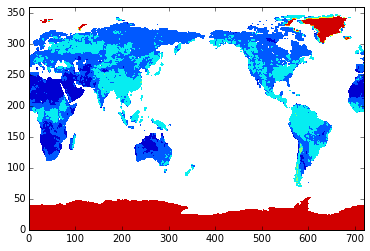

In [21]:
soilmvar = gfs.variables['Volumetric_Soil_Moisture_Content_depth_below_surface_layer']
# flip the data in latitude so North Hemisphere is up on the plot
soilm = soilmvar[0,0,::-1,:] 
print('shape=%s, type=%s, missing_value=%s' % \
      (soilm.shape, type(soilm), soilmvar.missing_value))
import matplotlib.pyplot as plt
%matplotlib inline
cs = plt.contourf(soilm)

##Packed integer data
There is a similar feature for variables with `scale_factor` and `add_offset` attributes.

- short integer data will automatically be returned as float data, with the scale and offset applied.  

## Dealing with dates and times
- time variables usually measure relative to a fixed date using a certain calendar, with units specified like ***`hours since YY:MM:DD hh-mm-ss`***.
- **`num2date`** and **`date2num`** convenience functions provided to convert between these numeric time coordinates and handy python datetime instances.  
- **`date2index`** finds the time index corresponding to a datetime instance.

In [22]:
from netCDF4 import num2date, date2num, date2index
timedim = sfctmp.dimensions[0] # time dim name
print('name of time dimension = %s' % timedim)
times = gfs.variables[timedim] # time coord var
print('units = %s, values = %s' % (times.units, times[:]))

name of time dimension = time2
units = Hour since 2015-07-11T06:00:00Z, values = [   0.    3.    6.    9.   12.   15.   18.   21.   24.   27.   30.   33.
   36.   39.   42.   45.   48.   51.   54.   57.   60.   63.   66.   69.
   72.   75.   78.   81.   84.   87.   90.   93.   96.   99.  102.  105.
  108.  111.  114.  117.  120.  123.  126.  129.  132.  135.  138.  141.
  144.  147.  150.  153.  156.  159.  162.  165.  168.  171.  174.  177.
  180.  183.  186.  189.  192.  195.  198.  201.  204.  207.  210.  213.
  216.  219.  222.  225.  228.  231.  234.  237.  240.  252.  264.  276.
  288.  300.  312.  324.  336.  348.  360.  372.  384.]


In [23]:
dates = num2date(times[:], times.units)
print([date.strftime('%Y-%m-%d %H:%M:%S') for date in dates[:10]]) # print only first ten...

['2015-07-11 06:00:00', '2015-07-11 09:00:00', '2015-07-11 12:00:00', '2015-07-11 15:00:00', '2015-07-11 18:00:00', '2015-07-11 21:00:00', '2015-07-12 00:00:00', '2015-07-12 03:00:00', '2015-07-12 06:00:00', '2015-07-12 09:00:00']


###Get index associated with a specified date, extract forecast data for that date.

In [24]:
from datetime import datetime, timedelta
date = datetime.now() + timedelta(days=3)
print(date)
ntime = date2index(date,times,select='nearest')
print('index = %s, date = %s' % (ntime, dates[ntime]))

2015-07-14 07:22:39.579246
index = 24, date = 2015-07-14 06:00:00


###Get temp forecast for Boulder (near 40N, -105W)
- use function **`getcloses_ij`** we created before...

In [25]:
lats, lons = gfs.variables['lat'][:], gfs.variables['lon'][:]
# lats, lons are 1-d. Make them 2-d using numpy.meshgrid.
lons, lats = np.meshgrid(lons,lats)
j, i = getclosest_ij(lats,lons,40,-105)
fcst_temp = sfctmp[ntime,j,i]
print('Boulder forecast valid at %s UTC = %5.1f %s' % \
      (dates[ntime],fcst_temp,sfctmp.units))

Boulder forecast valid at 2015-07-14 06:00:00 UTC = 296.8 K


##Simple multi-file aggregation

What if you have a bunch of netcdf files, each with data for a different year, and you want to access all the data as if it were in one file?

In [26]:
!ls -l data/prmsl*nc

-rw-r--r--  1 jwhitaker  staff  8985332 Jul 10 06:43 data/prmsl.2000.nc
-rw-r--r--  1 jwhitaker  staff  8968789 Jul 10 06:43 data/prmsl.2001.nc
-rw-r--r--  1 jwhitaker  staff  8972796 Jul 10 06:43 data/prmsl.2002.nc
-rw-r--r--  1 jwhitaker  staff  8974435 Jul 10 06:43 data/prmsl.2003.nc
-rw-r--r--  1 jwhitaker  staff  8997438 Jul 10 06:43 data/prmsl.2004.nc
-rw-r--r--  1 jwhitaker  staff  8976678 Jul 10 06:43 data/prmsl.2005.nc
-rw-r--r--  1 jwhitaker  staff  8969714 Jul 10 06:43 data/prmsl.2006.nc
-rw-r--r--  1 jwhitaker  staff  8974360 Jul 10 06:43 data/prmsl.2007.nc
-rw-r--r--  1 jwhitaker  staff  8994260 Jul 10 06:43 data/prmsl.2008.nc
-rw-r--r--  1 jwhitaker  staff  8974678 Jul 10 06:43 data/prmsl.2009.nc
-rw-r--r--  1 jwhitaker  staff  8970732 Jul 10 06:43 data/prmsl.2010.nc
-rw-r--r--  1 jwhitaker  staff  8976285 Jul 10 06:43 data/prmsl.2011.nc


**`MFDataset`** uses file globbing to patch together all the files into one big Dataset.
You can also pass it a list of specific files.

Limitations:

- It can only  aggregate the data along the leftmost dimension of each variable.
- only works with `NETCDF3`, or `NETCDF4_CLASSIC` formatted files.
- kind of slow.

In [27]:
mf = netCDF4.MFDataset('data/prmsl*nc')
times = mf.variables['time']
dates = num2date(times[:],times.units)
print('starting date = %s' % dates[0])
print('ending date = %s'% dates[-1])
prmsl = mf.variables['prmsl']
print('times shape = %s' % times.shape)
print('prmsl dimensions = %s, prmsl shape = %s' %\
     (prmsl.dimensions, prmsl.shape))

starting date = 2000-01-01 00:00:00
ending date = 2011-12-31 00:00:00
times shape = 4383
prmsl dimensions = (u'time', u'lat', u'lon'), prmsl shape = (4383, 91, 180)


## Closing your netCDF file

It's good to close netCDF files, but not actually necessary when Dataset is open for read access only.


In [28]:
f.close()
gfs.close()

##That's it!

Now you're ready to start exploring your data interactively.

To be continued with **Writing netCDF data** ....